In [10]:
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from visualkeras import layered_view
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, UpSampling2D, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50, MobileNet, MobileNetV2, MobileNetV3Small

from gand.data import data
from gand.config import MLConfig
from gand.preprocessing import utils
from gand.visualisation import visualise
from gand.models import models, architecture

import pandas as pd
from tabulate import tabulate
from tqdm.keras import TqdmCallback
from sklearn.metrics import classification_report

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
dataset = fashion_mnist
EPOCHS = 100
BATCH_SIZE = MLConfig.BATCH_SIZE

loss = "categorical_crossentropy"
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9)
metrics = ["accuracy"]

g_model_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/mnist/gen_model_e-200.h5')
g_model_fashion_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/fashion_mnist/gen_model_e-536.h5')
g_model_cifar10 = load_model(Path.cwd() / 'notebooks/models/cgan/cifar10/gen_model_e-553.h5')
g_model = g_model_fashion_mnist

train_with_gan = True
imbalance_data = False

reshape_image = True

train_type = 0

TRANSFER_LEARNING_MODEL = ResNet50
TRANSFER_LEARNING_PREPROCESSOR = tf.keras.applications.resnet50.preprocess_input

In [38]:
name = 'normal'
if train_with_gan:
    name = 'gans'
elif imbalance_data:
    name = 'imbalanced'

MLConfig.TYPE_NAMES = [f'{name}-{TRANSFER_LEARNING_MODEL().name.capitalize()}']
print(MLConfig.TYPE_NAMES)

['gans-Resnet50']


In [39]:
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

if len(X_train_real.shape) == 3:
    X_train_real = np.expand_dims(X_train_real, axis=-1)
    X_test_real = np.expand_dims(X_test_real, axis=-1)
    
    X_train_real = np.repeat(X_train_real, 3, axis=-1)
    X_test_real = np.repeat(X_test_real, 3, axis=-1)

    if reshape_image:
        X_train_real = np.array(tf.image.resize(X_train_real, [32,32]))
        X_test_real = np.array(tf.image.resize(X_test_real, [32,32]))

X_train_real = TRANSFER_LEARNING_PREPROCESSOR(X_train_real)
X_test_real = TRANSFER_LEARNING_PREPROCESSOR(X_test_real)

print(X_train_real.min(), X_train_real.max(), X_test_real.min(), X_test_real.max())

y_train_real = to_categorical(y_train_real, num_classes=10)
y_test_real = to_categorical(y_test_real, num_classes=10)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) fashion_mnist
-123.68 151.061 -123.68 151.061
(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10) fashion_mnist
(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10) fashion_mnist


In [53]:
model = load_model(Path.cwd() / Path(f'reports/models/{dataset_name}/{MLConfig.TYPE_NAMES[train_type]}/E_{EPOCHS:03d}/{MLConfig.TYPE_NAMES[train_type]}.h5'))
model.name, EPOCHS

('gans-Resnet50', 100)

In [54]:
model.layers

In [41]:
_, acc = model.evaluate(X_train_real, y_train_real)
_, acc = model.evaluate(X_test_real, y_test_real)

y_pred = np.argmax(model.predict(X_train_real), axis=-1)
report = classification_report(np.argmax(y_train_real, axis=1), y_pred)
print(report)

y_pred = np.argmax(model.predict(X_test_real), axis=-1)
report = classification_report(np.argmax(y_test_real, axis=1), y_pred)
print(report)

1875/1875 [==============================] - 42s 22ms/step
              precision    recall  f1-score   support

           0       0.69      0.89      0.77      6000
           1       0.98      0.96      0.97      6000
           2       0.85      0.62      0.72      6000
           3       0.77      0.83      0.80      6000
           4       0.68      0.70      0.69      6000
           5       0.97      0.90      0.93      6000
           6       0.59      0.54      0.57      6000
           7       0.89      0.93      0.91      6000
           8       0.98      0.95      0.97      6000
           9       0.94      0.96      0.95      6000

    accuracy                           0.83     60000
   macro avg       0.83      0.83      0.83     60000
weighted avg       0.83      0.83      0.83     60000

313/313 [==============================] - 9s 24ms/step
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      1000
           1     

In [69]:
model = load_model(Path.cwd() / Path(f'reports/models/ResNet50-savious.h5'))
model.name

'ResNet50'

In [70]:
model.layers[-2].rate

0.5

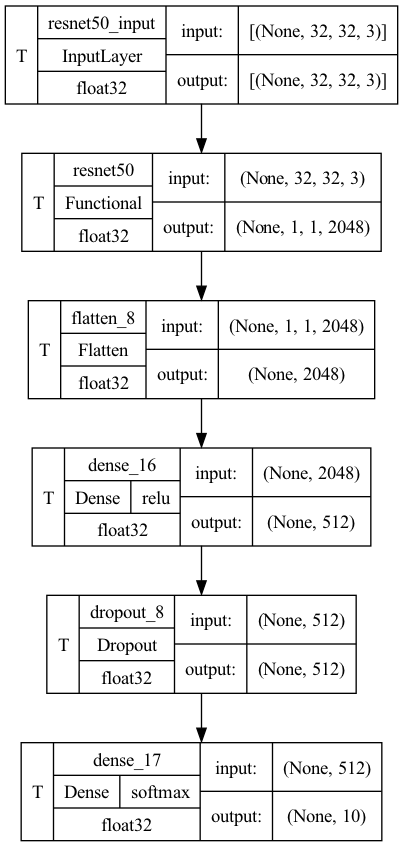

In [71]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_dtype=True,
          show_layer_names=True, 
           show_shapes=True, 
           show_trainable=True, 
           show_layer_activations=True)

# EVERYTHING ELSE

In [32]:
base_model = TRANSFER_LEARNING_MODEL(weights='imagenet', include_top=False, 
                                     input_shape=(224, 224, 3))

upsamp = 8

input = Input(shape=(28, 28, 3))
layer = UpSampling2D(size=(upsamp, upsamp))(input)
assert layer.shape == (None, 224, 224, 3)

layer = base_model(layer)
layer = GlobalAveragePooling2D()(layer)
layer = Flatten()(layer)
layer = Dense(1024, activation='relu')(layer)
layer = Dropout(0.25)(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(0.5)(layer)
output = Dense(10, activation='softmax')(layer)

model = Model(input, output, name=MLConfig.TYPE_NAMES[train_type])

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=loss, metrics=metrics)

model.summary()

Model: "normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                            

In [33]:
base_model.name

'MobilenetV3small'

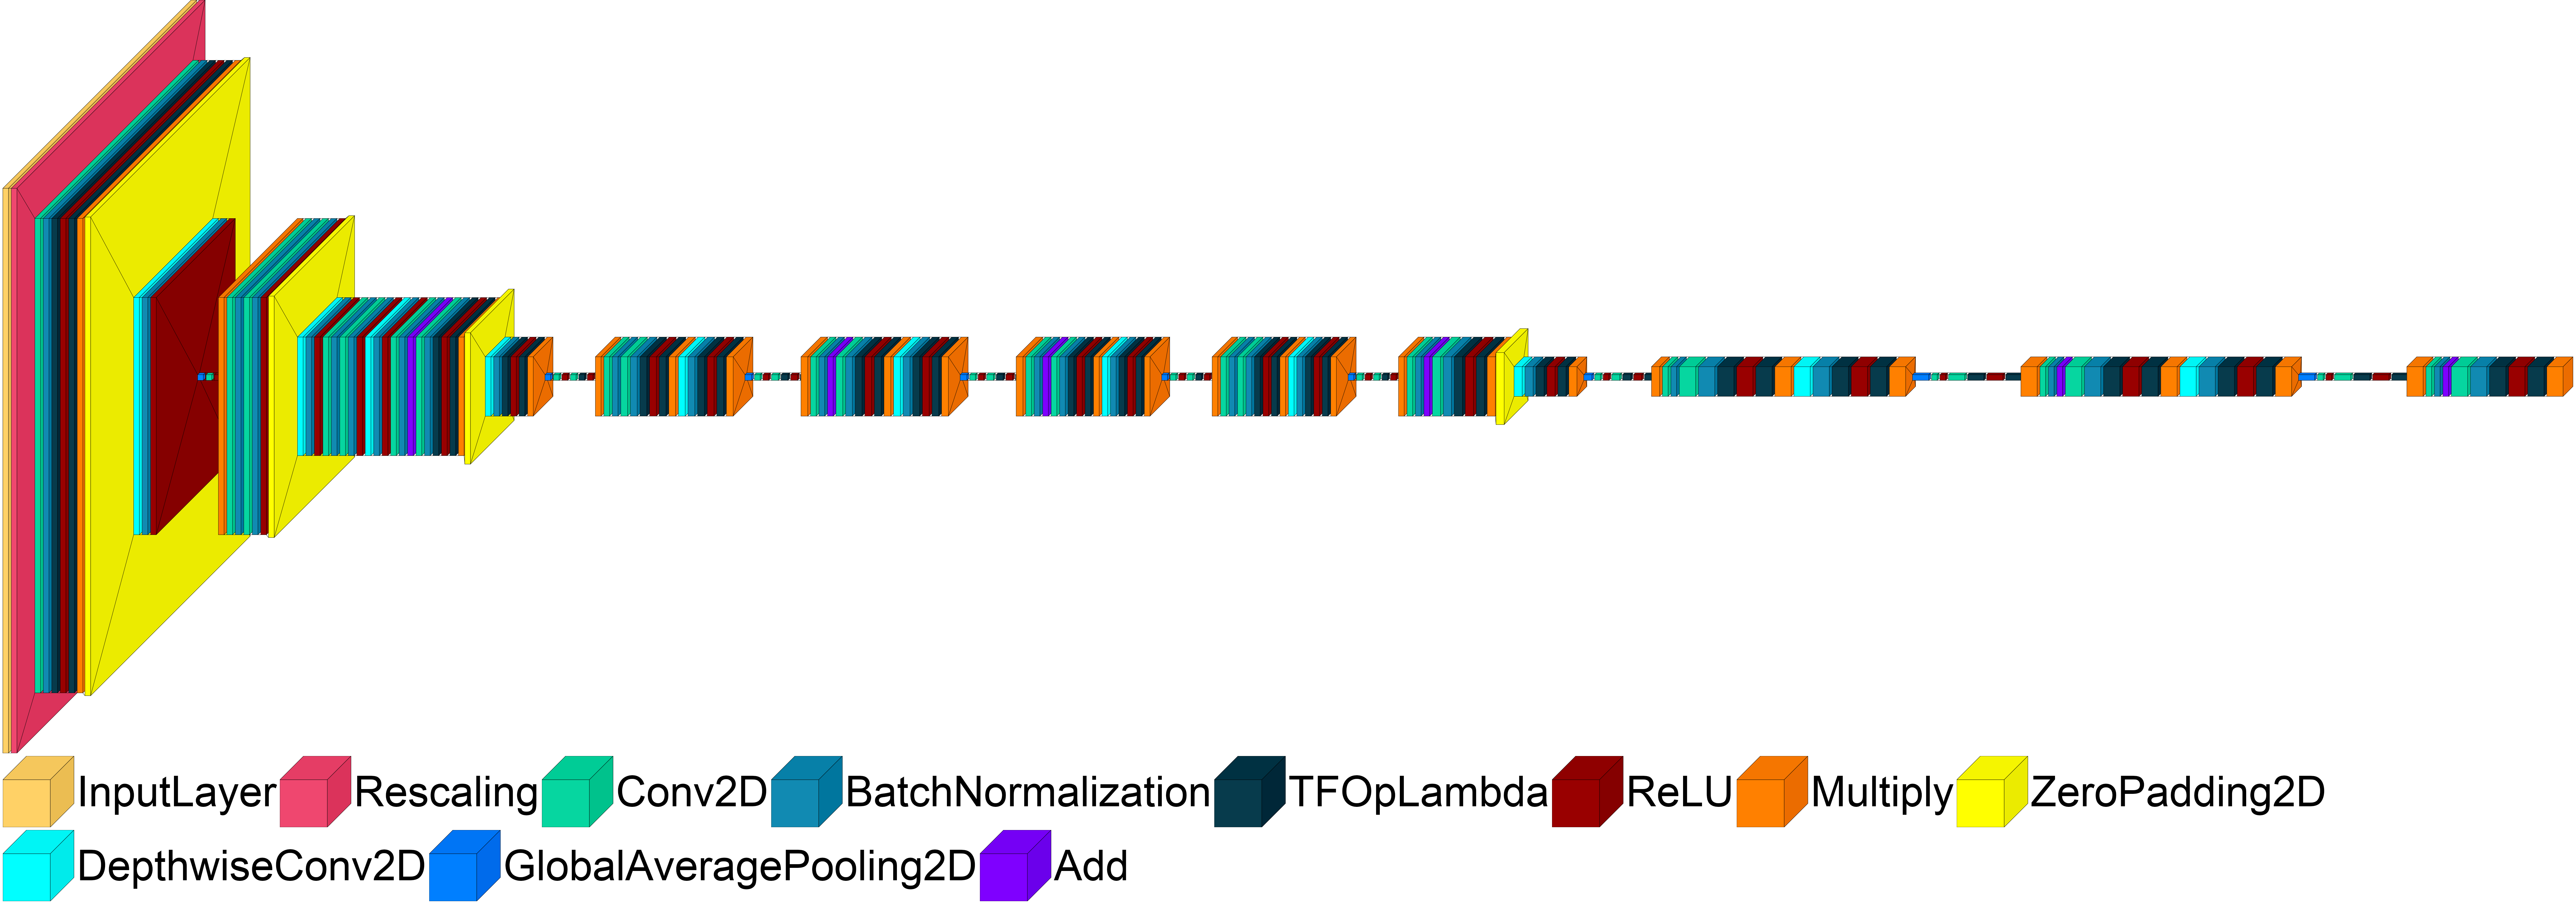

In [34]:
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.truetype('arial.ttf', 150)
color_map = defaultdict(dict)
color_map[tf.keras.layers.ReLU]['fill'] = '#990000'
color_map[tf.keras.layers.Multiply]['fill'] = '#FF8000'
color_map[tf.keras.layers.ZeroPadding2D]['fill'] = '#FFFF00'
color_map[tf.keras.layers.DepthwiseConv2D]['fill'] = '#00FFFF'
color_map[tf.keras.layers.GlobalAveragePooling2D]['fill'] = '#007FFF'
color_map[tf.keras.layers.Add]['fill'] = '#7F00FF'


layered_view(base_model, to_file=f'{MLConfig.FIGURES_PATH.joinpath(f"{base_model.name}.png")}', 
             scale_xy=15, legend=True, color_map=color_map, font=font)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(X, y), (_, _) = cifar10.load_data()
axs[0].plot(X[idx][0])
axs[0].set_yticks(np.arange(X.min(), X.max(), 40, dtype=np.int32))

X = tf.keras.applications.resnet.preprocess_input(X)
axs[1].plot(X[idx][0])
axs[1].set_yticks(np.arange(X.min(), X.max(), 40, dtype=np.int32))

X = tf.keras.applications.mobilenet.preprocess_input(X)
axs[2].plot(X[idx][0])
axs[2].set_yticks(np.arange(X.min(), X.max(), dtype=np.int32))

plt.show();

Input 255 0
ResNet 151.061 -117.68
MobileNet 1.0 -1.0
VGG16 1.0 -1.0


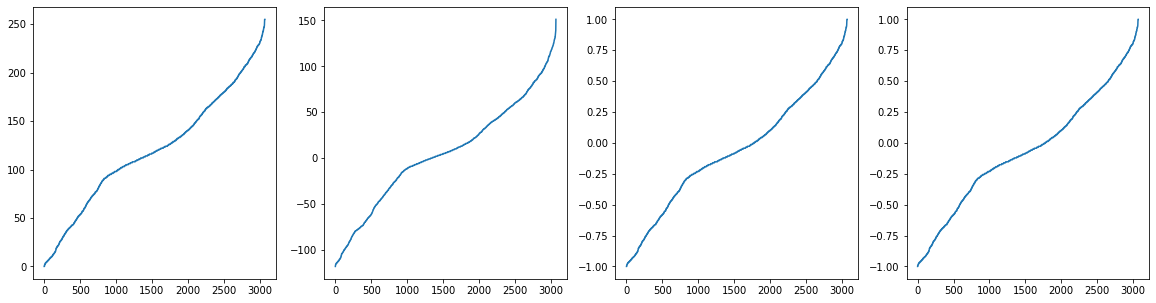

In [94]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
(X, y), (_, _) = cifar10.load_data()

idx = 19424

X_resnet = tf.keras.applications.resnet.preprocess_input(X)
X_mobilenet = tf.keras.applications.mobilenet.preprocess_input(X)
X_vgg16 = tf.keras.applications.inception_v3.preprocess_input(X)

arr = sorted(X[idx].flatten())
arr_resnet = sorted(X_resnet[idx].flatten())
arr_mobilenet = sorted(X_mobilenet[idx].flatten())
arr_vgg16 = sorted(X_vgg16[idx].flatten())

axs[0].plot(arr)
print('Input', max(arr), min(arr))

axs[1].plot(arr_resnet)
print('ResNet', max(arr_resnet), min(arr_resnet))

axs[2].plot(arr_mobilenet)
print('MobileNet', max(arr_mobilenet), min(arr_mobilenet))

axs[3].plot(arr_vgg16)
print('VGG16', max(arr_vgg16), min(arr_vgg16))

plt.show();